# Collision-Induced Absorption

In this notebook, we'll explore how pyROX calculates the collision-induced absorption (CIA) coefficients for H$_2$-H$_2$ collisions, using data from HITRAN. 

In [1]:
from pyROX import utils, cross_sections

## Configuration parameters
The parameters given in the [configuration file](https://github.com/samderegt/pyROX/blob/main/examples/cia_hitran_h2_h2/cia_hitran_h2_h2.py) `examples/cia_hitran_h2_h2/cia_hitran_h2_h2.py` are similar to those used in the "line-by-line" calculations outlined in the previous notebooks. In the cell below, we'll define the database, directory-structure, URLs to download, and the wavenumber grid. 

In [2]:
# Basic information on database and species
database = 'cia_hitran' # Can be ['cia_hitran', 'cia_borysow']
species  = 'h2-h2'      # Species name

# Input/output-directories
input_data_dir  = './examples/cia_hitran_h2_h2/input_data/'
output_data_dir = './examples/cia_hitran_h2_h2/'

# Instructions to download from HITRAN database
urls = [
    'https://hitran.org/data/CIA/H2-H2_2011.cia', 
    'https://hitran.org/data/CIA/supplementary/H2-H2_eq_2018.cia', # Extends to lower temperatures
]

# Wavenumber grid
wave_min = 0.3; wave_max = 250.0 # [um]
delta_nu = 10. # [cm^-1] # Can be sparse for CIA calculations

We'll download two files `H2-H2_2011.cia` and `H2-H2_eq_2018.cia` of which the latter extends down to lower temperatures ($200<T[\mathrm{K}]<3000$ vs. $40<T[\mathrm{K}]<400$; see the [HITRAN documentation](https://hitran.org/data/CIA/CIA_Readme.pdf)). When defining the files to calculate, we can add two callable functions in a tuple like `(filename, T_mask(T_grid), nu_mask(nu_grid))`. 

In the example below, pyROX will crop the temperature-grid that is included in the `H2-H2_2011.cia` file to $T\geq 400\ \mathrm{K}$. For the second file, `H2-H2_eq_2018.cia`, we don't apply any masks so any CIA coefficients below $T<400\ \mathrm{K}$ will come from it.

In [3]:
# Extents of the CIA data
T_mask_1 = lambda T: (T>=400) & (T<=3000)
nu_mask_1 = lambda nu: (nu>=20) & (nu<=10000) # [cm^-1]

# T_mask_2 = lambda T: (T>=40) & (T<=400)
# nu_mask_2 = lambda nu: (nu>=0) & (nu<=2400) # [cm^-1]

# Input-data files
files = dict(
    cia = [
        (f'{input_data_dir}/H2-H2_2011.cia', T_mask_1, nu_mask_1),
        #(f'{input_data_dir}/H2-H2_eq_2018.cia', T_mask_2, nu_mask_2),
        f'{input_data_dir}/H2-H2_eq_2018.cia',
    ]
)

## Calculating CIA coefficients
We now have all the parameters to download the data and calculate the CIA coefficients. In the next cell, we'll set up the `config` object and execute the download, calculations, saving and plotting. This is equivalent to running the command
```bash
pyROX examples/cia_hitran_h2_h2/cia_hitran_h2_h2.py -d -c -s -p
```


Updating configuration with new parameters
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "database" as "cia_hitran".
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "species" as "h2-h2".
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "input_data_dir" as "./examples/cia_hitran_h2_h2/input_data/".
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "output_data_dir" as "./examples/cia_hitran_h2_h2/".
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "urls" as ['https://hitran.org/data/CIA/H2-H2_2011.cia', 'https://hitran.org/data/CIA/supplementary/H2-H2_eq_2018.cia'].
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "files" as {'cia': [('./examples/cia_hitran_h2_h2/input_data//H2-H2_2011.cia', <function <lambda> at 0x7f994c7befc0>, <function <lambda> at 0x7f994c7bef20>), './examples/cia_hitran_h2_h2/input_data//H2-H2_eq_2018.cia']}

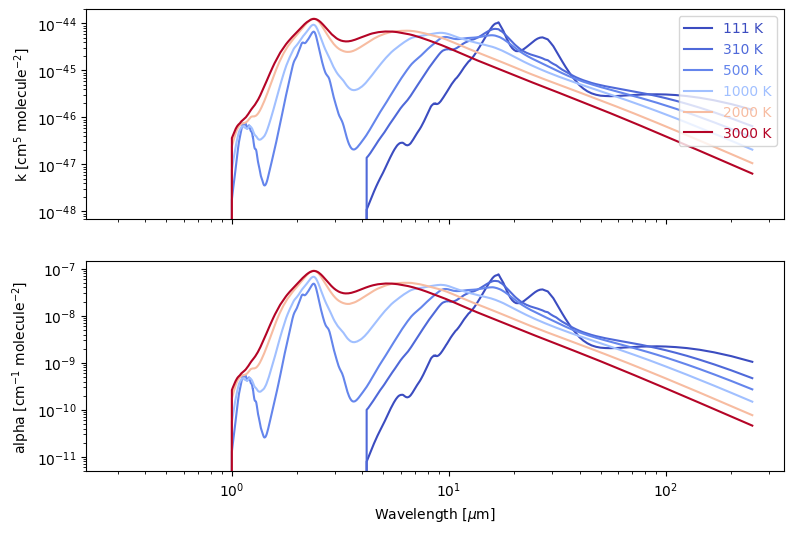

In [4]:
# Setup a configuration object (done automatically when running pyROX from the command line)
config = utils.update_config_with_args(    
    database=database, species=species, 
    input_data_dir=input_data_dir, output_data_dir=output_data_dir, urls=urls, files=files,
    wave_min=wave_min, wave_max=wave_max, delta_nu=delta_nu, 
)

# Download from the HITRAN database
data = cross_sections.load_data_object(config, download=True)

data.calculate_temporary_outputs(
    #overwrite=False, # If True, answer "yes" to all overwrite prompts
)

data.save_combined_outputs(
    #overwrite=False, # If True, answer "yes" to all overwrite prompts
)

fig, ax = data.plot_combined_outputs(
    T_to_plot=[100,300,500,1000,2000,3000], 
    return_fig_ax=True
)
fig.show()

<div class="alert alert-warning">
    <strong>Important:</strong> The final output-file is saved as a compressed `hdf5`-type. It has 4 datasets:
    <ul>
        <li>`T_grid`: Temperature grid points (in K).</li>
        <li>`wave`: Wavelength grid points (in m).</li>
        <li>`log10(k)`: Base-10 logarithm of the $k$-coefficient (in log10[m<sup>5</sup> molecule<sup>-2</sup>]) with shape (`wave`, `T_grid`).</li>
        <li>`log10(alpha)`: Base-10 logarithm of the $\alpha$-coefficient (in log10[m<sup>-1</sup> molecule<sup>-2</sup>]) with shape (`wave`, `T_grid`).</li>
    </ul>
</div>

pyROX saves the `k` and `alpha` coefficients, which are scalings of each other (see Eq. 3 of [Karman et al. 2019](https://ui.adsabs.harvard.edu/abs/2019Icar..328..160K/abstract)). To convert the $\alpha$-coefficient into a cross-section, you can multiply by the number density ($N_i$, in [$\mathrm{m^{-3}}$]) of each collision-component:
$$
\sigma[\mathrm{m^2}] = \frac{\alpha}{L_0^2} \cdot \left(\frac{N_1\cdot N_2}{N_\mathrm{tot}}\right) = \frac{\alpha}{L_0^2} \cdot \mathrm{VMR}_1\cdot \mathrm{VMR}_2\cdot N_\mathrm{tot}, 
$$
where $L_0$ is the [Loschmidt constant](https://en.wikipedia.org/wiki/Loschmidt_constant). 

## Converting to pRT3-format
pyROX also offers support to convert the saved `alpha` into an `h5`-file that can be read in with [petitRADTRANS v3](https://petitradtrans.readthedocs.io/en/latest/content/adding_opacities.html). To generate the right filename and add metadata to the `h5`-file, we'll have to add the `pRT3_metadata` dictionary to the `config` object. Notice how the molecular mass (in amu) of each collision-component is specified. 

In [5]:
# Metadata to be stored in pRT3's .h5 file
pRT3_metadata = dict(
    DOI = ['10.1021/jp109441f', '10.3847/1538-4365/aaa07a'], 
    mol_mass = [2.0,2.0],
    mol_name = ['H2','H2'],
)

# Update the configuration parameters
config = utils.update_config_with_args(
    config=config,     # Update the previous configuration
    pRT3_metadata=pRT3_metadata, # Add metadata
)
# Re-load the data object
data = cross_sections.load_data_object(config, download=False)

# Convert to the pRT3 format
data.convert_to_pRT3(contributor='Your name!')


Updating configuration with new parameters
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "pRT3_metadata" as {'DOI': ['10.1021/jp109441f', '10.3847/1538-4365/aaa07a'], 'mol_mass': [2.0, 2.0], 'mol_name': ['H2', 'H2']}.

------------------------------------------------------------
  Collision-Induced Absorption from HITRAN
------------------------------------------------------------


Reading parameters from the configuration file
/net/lem/data2/regt/pyROX/pyROX/utils.py:245 UserWarning: Please make sure that the following parameters are given in the expected units:
  - delta_nu [cm^-1]
  - wave_max [um]
  - wave_min [um]


Wavelength-grid:
  Wavelength: 0.30 - 250 um
  Wavenumber: 40 - 33333 cm^-1
  Fixed wavenumber-spacing: 10.001 cm^-1
  Number of grid points: 3330
  Adaptive grid: False

Converting to petitRADTRANS-v3.0 format
  Saved to "/net/lem/data2/regt/pyROX/examples/cia_hitran_h2_h2/H2--H2-NatAbund__HITRAN.R1000_0.3-250mu.ciatable.petitRADTRANS.h5